In [33]:
import urllib.parse
import re
import time
from urllib.request import build_opener, Request
from bs4 import BeautifulSoup

In [38]:
def get_num_results(search_options, start_date, end_date):
    # Set the user agent to be used when sending the request to Google Scholar
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.109 Safari/537.36'

    # print(search_options)

    # Set the query parameters for the search query
    query_params = {
        'as_q': search_options['query'],  # The search query
        'as_ylo': start_date,  # The lower limit of the year range for the publication date
        'as_yhi': end_date,  # The upper limit of the year range for the publication date
        
        'as_occt': search_options.get('as_occt', ''), # The query on the only title of the page
        'as_epq' : search_options.get('as_epq', ''), # With the exact phrase
        'as_oq' : search_options.get('as_oq', ''), # with at least one of the words
        'as_eq' : search_options.get('as_eq', ''), # Without the words
        'as_sauthors': search_options.get('as_sauthors', ''), #Return articles authored by
        'as_publication': search_options.get('as_publication', ''), # Return articles published in
        
        'as_sdt': search_options.get('as_sdt', ''), # Include patents
        'as_vis': search_options.get('visibility', ''),  # Include citations
        
    }
    # print(query_params)

    # Add any additional query parameters specified by the user
    for key, value in search_options.items():
        if isinstance(value, dict) and 'sample_value' in value and value['sample_value'] is not None and value['sample_value'] != '':
            query_params[value['query_param']] = value['sample_value']

    # Construct the URL for the search query
    url = "https://scholar.google.com/scholar?" + urllib.parse.urlencode(query_params)
    # print(url)

    # Send a request to the Google Scholar website with the specified user agent
    opener = build_opener()
    request = Request(url=url, headers={'User-Agent': user_agent})
    handler = opener.open(request)
    html = handler.read()

    # Parse the HTML content of the response using BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Find the div element that contains the number of search results
    div_results = soup.find("div", {"id": "gs_ab_md"})

    # If the div element is found, extract the number of search results
    if div_results is not None:
        res = re.findall(r'(\d+).?(\d+)?.?(\d+)?\s', div_results.text)

        # If the number of search results cannot be extracted, set it to 0
        if res == []:
            num_results = '0'
            success = True
        else:
            num_results = ''.join(res[0])
            success = True
    else:
        # If the div element is not found, set the number of search results to 0
        success = False
        num_results = 0

    # Return the number of search results and a boolean indicating whether the search was successful
    return num_results, success

def remover(my_string = ""):
    # Define a function called 'remover' that takes a string as input and removes any character that is not a letter, a number, or a space from the string
    values = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
    # Define a list of all valid characters (letters, numbers, and spaces)
    for item in my_string:
        # For each character in the input string
        if item not in values:
            # If the character is not valid
            my_string = my_string.replace(item, "")
            # Replace the character with an empty string
    return my_string
    # Return the updated string

def main(search_options):

    with open('occurence_for_{}_{}_{}.csv'.format(remover(search_options['query']),
                                                  search_options['start_year'],
                                                  search_options['end_year']), 'w') as fp:
        # Open a file named 'occurence_for_{query}_{start_year}_{end_year}.csv', where 'query' is the cleaned version of the search query and 'start_year' and 'end_year' are the years of the search period
        fp.write("year,results\n")
        # Write a header row to the file
        print("year,results")
        # Print the header row to the console

        for date in range(search_options['start_year'], search_options['end_year'] + 1):
            # For each year in the search period
            num_results, success = get_num_results(search_options, date, date)
            # Call the 'get_num_results' function to get the number of search results for the current year, and whether the request was successful
            if not(success):
                # If the request was not successful
                print("It seems that you made too many requests to Google Scholar. Please wait a couple of hours and try again.")
                # Print an error message to the console
                break
                # Exit the loop
            year_results = "{0},{1}".format(date, num_results)
            # Format the year and number of search results as a string
            print(year_results)
            # Print the string to the console
            fp.write(year_results + '\n')
            # Write the string to the file
            time.sleep(0.8)
            # Pause the program for 0.8 seconds to avoid making too many requests to Google Scholar
        fp.close()
        # Close the file

In [39]:
search_options = {
    'query': 'deep learning',
    'start_year': 2016,
    'end_year': 2023,
    'as_occt': 'title', # In the title/anywhere of the article ('any' for anywhere in the article and  title for in the tiltle only)
    
    # Advanced Search 
    'as_epq': '', # With the exact phrase
    'as_oq': '', # With at least one of the words
    'as_eq': '', # Without the words
    'as_sauthors': '', # Return articles authored by | Ghulam Mujtaba, Donald Adjeroh, Eun-Seok Ryu, Ashish Vaswani 
    'as_publication': 'IEEE', # Return articles published in | IEEE, Springer, arXiv
    
    'as_sdt': '', # Include patents (null for no patents and 7 for patents)
    'visibility': '1', # include citations (null for citation and 1 for no citations)
}

main(search_options)

csv_fileName = 'occurence_for_'+search_options['query']+'_'+str(search_options['start_year'])+'_'+str(search_options['end_year'])+'.csv'

year,results
2016,619
2017,1510
2018,2760
2019,4690
2020,5880
2021,7470
2022,8430
2023,1480


In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def generate_graphs(file_path):
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Set the year column as the index of the DataFrame
    df.set_index('year', inplace=True)

    # Create a bar chart of the search results by year
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(df.index, df['results'], color='blue')
    ax.set_xlabel('Year')
    ax.set_ylabel('Occurrence')
    ax.set_title("Occurrence of keyword '{}' over time".format(search_options['query']))
    plt.savefig(os.path.join(os.path.dirname(file_path), 'bar_chart.png'))

    # Create a line chart of the search results by year
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df.index, df['results'], color='red', marker='o')
    ax.set_xlabel('Year')
    ax.set_ylabel('Occurrence')
    ax.set_title("Occurrence of keyword '{}' over time".format(search_options['query']))
    plt.savefig(os.path.join(os.path.dirname(file_path), 'line_chart.png'))

    # Display the graphs
    plt.show()

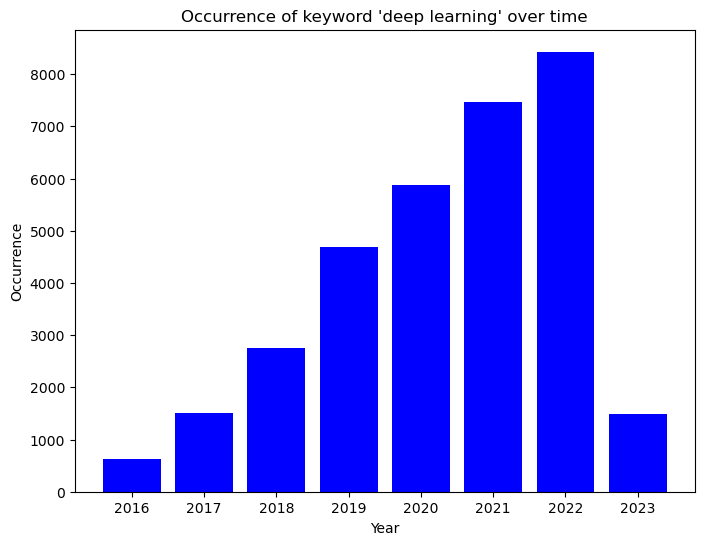

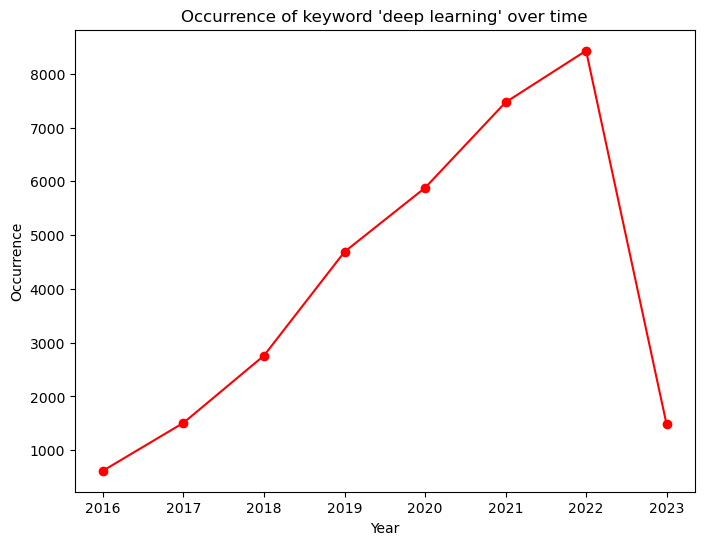

In [37]:
generate_graphs(csv_fileName)